# Frozen Lake Monte Carlo Control

In [1]:
using PyPlot

In [2]:
using Random

In [3]:
using ReinforcementLearning 

Firstly, we will define our environment. We will make it recognizable for the [<tt>ReinforcementLearning.jl</tt>]( https://juliareinforcementlearning.org/).

Let us start with predefined constants and functions:

In [4]:
#actions coded as :left => 1, :down => 2, :right => 3, :up => 4
#arrows are corresponding to actions
arrows = Dict(1 => '⇐', 2 => '⇓', 3 => '⇒', 4 => '⇑');

grid4x4= ['S' 'F' 'F' 'F';
        'F' 'H' 'F' 'H';
        'F' 'F' 'F' 'H';
        'H' 'F' 'F' 'G'];

grid8x8 =['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'F' 'F' 'H' 'F' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'F';
        'F' 'H' 'H' 'F' 'F' 'F' 'H' 'F';
        'F' 'H' 'F' 'F' 'H' 'F' 'H' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'G';];

In [5]:
#Auxilliary functions
function get_grid(dim, p_holes, seed = 234)
    Random.seed!(seed)
    grid = [rand() < p_holes ? 'H' : 'F' for i in 1:dim, j in 1:dim]
    grid[1,1] = 'S'
    grid[end,end] = 'G'
    return grid
end;

function random_policy(grid,actions = actions)
    P = rand(Int,size(grid))
    for i = 1:length(grid)
        P[i] = rand(1:length(actions))
    end
    return P
end;

function print_policy(P, grid, arrows = arrows)
    Policy = rand(Char,size(grid))
    for i = 1:length(grid)
        if grid[i] == 'F' || grid[i] == 'S' 
            Policy[i] = arrows[P[i]]
        elseif grid[i] == 'H' 
            Policy[i] = '⦷'
        else
            Policy[i] = grid[i]
        end
    end
    return Policy
end;

Now, we will define the environment as a mutable struct:

In [6]:
mutable struct FrozenLakeEnv <: AbstractEnv
    reward::Union{Nothing, Float64}
    rewards::Dict{Char, Float64} 
    actions::Dict{Int64, Tuple{Int64, Int64}}  
    world::Matrix{Char} 
    ES::Bool 
    position::Int 
end;
Main.FrozenLakeEnv

FrozenLakeEnv

and define a constructor function of Frozen Lake environment:

In [7]:
function FrozenLakeEnv(grid::Union{Int,Symbol} = :grid4x4; ES::Bool = false) 
    if typeof(grid) == Int
        world = get_grid(grid, 0.1)
    elseif grid == :grid4x4
        world = grid4x4
    elseif grid == :grid8x8
        world = grid8x8
    else
        @error "unknown grid"
    end
    ES == true ? position = rand(1:length(world)) : position = 1
    return FrozenLakeEnv(nothing, Dict('S' => -0.05, 'G' => 1.0, 'H' => -1.0, 'F' => -0.05),
    Dict(1 => (0,-1), 2 => (1,0), 3 => (0,1), 4 => (-1,0)), 
        world, ES, position)
end;

Now, we must define the minimal interface of the environment. Without this functions code will not work properly:

In [8]:
#functions:
RLBase.action_space(env::FrozenLakeEnv) = Base.OneTo(length(env.actions)) # range 1:4
RLBase.state_space(env::FrozenLakeEnv) = Base.OneTo(length(env.world))
RLBase.reward(env::FrozenLakeEnv) = env.reward
RLBase.state(env::FrozenLakeEnv) = env.position # pozycja na mapie
RLBase.is_terminated(env::FrozenLakeEnv) = env.reward == 1.0 || env.reward == -1.0 
# terminujemy gre gdy dojdziemy do przelebli / do konca gry
function RLBase.reset!(env::FrozenLakeEnv) 
    env.reward = nothing
    env.ES == true ? env.position = rand(state_space(env)) : env.position = 1
end

# must-have functions

and the most important function that controls the  movement:

In [9]:
# najblizszy odpowidnik metody z pythona, ale dla konkretnego obiektu 
function (x::FrozenLakeEnv)(action)
    @assert action in action_space(x) # sprawdza czy akcja nalezy do przestrzeni akcji; else blad
    direction = x.actions[action] # bierzemy akcje (1|2|3|4); czyli kierunek (lewo|prawo|gora|dol)
    cartesian_state = (CartesianIndices(x.world)[x.position][1],
                        CartesianIndices(x.world)[x.position][2]) # indeksy pola - wspolrzedne
    sides = filter(y -> !(y in [direction, direction .* -1]), collect(values(x.actions)))
    # wyznaczaly lewo i prawo; 
    # nie wchcemy kierunku ktory wybralismy i kierunek do przodu (kierunek-1)
    p = rand()
    if p <= 0.8
        new_state = cartesian_state .+ direction
    elseif p <= 0.9
        new_state = cartesian_state .+ sides[1]
    else
        new_state = cartesian_state .+ sides[2]
    end
    # czy pole znajduje sie w wymiarach swiata (czy to nie sciana)
    if new_state[1] in (1:size(x.world,1)) && new_state[2] in (1:size(x.world,2))
        x.position = LinearIndices(x.world)[new_state[1],new_state[2]] # przenosimy pozycje
        x.reward = x.rewards[x.world[x.position]] 
        # mapujemy nagrode (ze slownika nagrod) - w 1 kroku, nie epizodzie(=1 GRA)
    else
        x.position = LinearIndices(x.world)[cartesian_state[1],cartesian_state[2]]
        x.reward = x.rewards[x.world[x.position]]
    end
end;

Now we could test if the Frozen Lake enviroment works and debug it if neccessary:

In [10]:
env = FrozenLakeEnv(:grid8x8, ES = false);
RLBase.test_runnable!(env);

Test Summary:                    | Pass  Total  Time
random policy with FrozenLakeEnv | 2000   2000  0.1s


In [11]:
env

# FrozenLakeEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Base.OneTo(64)`

## Action Space

`Base.OneTo(4)`

## Current State

```
1
```


[Hooks](https://juliareinforcementlearning.org/docs/How_to_use_hooks/) are one of the biggest advantages of the <tt>ReinforcementLearning.jl</tt> package. They allow us to collect some useful information about the training process. Here is the simple example how we could use them:

In [12]:
hook = TotalRewardPerEpisode() # co jedna epoke wyrzuc calkowita nagroda
TotalRewardPerEpisode(Float64[], 0.0, true) 
# pusta lista (od 1 iteracji), nagroda pierwotna =0, czy bedzie wykres

TotalRewardPerEpisode(Float64[], 0.0, true)

In [13]:
# uczymy agenta
# akcje od 1 do 4
# w naszym srodowisku env = frozen lake
# przez 200 000 iteracji
# chcemy zeby zwrucilo nagrody; wykonuje dzialanie, nie uczy sie
run(RandomPolicy(action_space(env)), env, StopAfterEpisode(200_000), hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


             ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
             ┌────────────────────────────────────────┐ 
          10 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⡀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⢀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⣯⣿⣯⣿⣭⣯⣯⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣯⣿⣯⣽⣿⣽⣿⣿⣿⣽⣿⣿⣽⣿⣭⣽⣯⣿⣽⣽⣽⣿⣯│ 
             │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
   Score     │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
             │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
             │⡿⢿⣿⣿⠿⣿⣿⣿⣿⣿⡿⣿⣿⢿⣿⣿⢻⣿⡿⣿⣿⢿⢻⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⢿│ 
             │⠀⢸⠟⡿⠀⡇⠸⣿⡟⣿⡇⠋⣿⠈⠙⢸⠘⢻⠃⠁⡏⢸⠈⡇⢸⠻⠇⣿⡇⠿⢸⠈⢿⠃⢸⢸⠘⠛⠀⢸│ 
             │⠀⠘⠀⠁⠀⠃⠀⠇⠀⠋⠁⠀⠀⠀⠀⠸⠀⠀⠀⠀⠁⠀⠀⠀⠸⠀⠀⠁⡇⠀⢸⠀⠀⠀⠸⠀⠀⠀⠀⠸│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠇⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -20 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             └─────────────────

TotalRewardPerEpisode([-1.4, -3.849999999999998, -2.500000000000001, -3.0500000000000007, -3.25, -4.049999999999997, -3.9999999999999973, -1.6, -1.5, -1.7000000000000002  …  -6.549999999999988, -1.5499999999999998, -2.0500000000000003, -2.850000000000001, -4.849999999999994, -4.999999999999994, -1.4, -1.8000000000000003, -2.650000000000001, -3.849999999999998], 0.0, true)

or in a more sophisticated case:

In [14]:
mcpolicy = QBasedPolicy(
           learner = MonteCarloLearner(
                   approximator=TabularQApproximator( # tworzy tabele stan/akcje i wybiera z niej
                       ;n_state = length(state_space(env)),
                       n_action = length(action_space(env)),
                        init = 0.0,
                   ),# sa inne opcje, ale pozniej na koljnych zajeciach
            γ = 0.999 # beta
               ),
           explorer = EpsilonGreedyExplorer(0.1)
       )
# strategia - QBasedPolicy
# learner - jak sie uczy
# explorer - jak esploruje przestrzen


typename(QBasedPolicy)
├─ learner => typename(MonteCarloLearner)
│  ├─ approximator => typename(TabularApproximator)
│  │  ├─ table => 4×64 Matrix{Float64}
│  │  └─ optimizer => typename(Flux.Optimise.InvDecay)
│  │     ├─ gamma => 1.0
│  │     └─ state => typename(IdDict)
│  ├─ γ => 0.999
│  ├─ kind => typename(ReinforcementLearningZoo.FirstVisit)
│  └─ sampling => typename(ReinforcementLearningZoo.NoSampling)
└─ explorer => typename(EpsilonGreedyExplorer)
   ├─ ϵ_stable => 0.1
   ├─ ϵ_init => 1.0
   ├─ warmup_steps => 0
   ├─ decay_steps => 0
   ├─ step => 1
   ├─ rng => typename(Random._GLOBAL_RNG)
   └─ is_training => true


In [15]:
run(mcpolicy, env, StopAfterEpisode(200_000), hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⢀⠀⠀⠀⠀⢀⢀⠀⠀⠀⢀⠀⠀⢀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠻⠿⠻⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⡿⡿⠿⠿⠿⠻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
   Score      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⡟⣿⣿⢻⣿⡿⣿⡿⣿⡿⠿⡟⣿⣿⣿⣿⣿⣿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠁⡇⠙⠃⢸⠉⠀⢸⠃⡿⠁⠀⠁⣿⡿⡇⠃⣿⢿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠇⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⡿⠀⠇⠀⠈⠈│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -200 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

TotalRewardPerEpisode([-1.4, -3.849999999999998, -2.500000000000001, -3.0500000000000007, -3.25, -4.049999999999997, -3.9999999999999973, -1.6, -1.5, -1.7000000000000002  …  -15.350000000000069, -10.700000000000003, -6.799999999999987, -3.6499999999999986, -15.050000000000065, -14.550000000000058, -8.349999999999982, -45.949999999999584, -7.699999999999984, -12.300000000000026], 0.0, true)

In [16]:
# probuje sie uczyc

In [17]:
agentMC = Agent(
           policy = mcpolicy,
           trajectory = VectorSARTTrajectory() # vektor: stan akcja nagroda ile do konca
       )
# poza strategii gent musi przechowywac trajektorie 

typename(Agent)
├─ policy => typename(QBasedPolicy)
│  ├─ learner => typename(MonteCarloLearner)
│  │  ├─ approximator => typename(TabularApproximator)
│  │  │  ├─ table => 4×64 Matrix{Float64}
│  │  │  └─ optimizer => typename(Flux.Optimise.InvDecay)
│  │  │     ├─ gamma => 1.0
│  │  │     └─ state => typename(IdDict)
│  │  ├─ γ => 0.999
│  │  ├─ kind => typename(ReinforcementLearningZoo.FirstVisit)
│  │  └─ sampling => typename(ReinforcementLearningZoo.NoSampling)
│  └─ explorer => typename(EpsilonGreedyExplorer)
│     ├─ ϵ_stable => 0.1
│     ├─ ϵ_init => 1.0
│     ├─ warmup_steps => 0
│     ├─ decay_steps => 0
│     ├─ step => 54777861
│     ├─ rng => typename(Random._GLOBAL_RNG)
│     └─ is_training => true
└─ trajectory => typename(Trajectory)
   └─ traces => typename(NamedTuple)
      ├─ state => 0-element Vector{Int64}
      ├─ action => 0-element Vector{Int64}
      ├─ reward => 0-element Vector{Float32}
      └─ terminal => 0-element Vector{Bool}


In [18]:
run(agentMC, env, StopAfterEpisode(200_000), hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⡀⠀⠀⢀⡀⠀⢀⠀⢀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⠻⠿⠿⠿⠿⠿⠿⠿⠿⡿⡿⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠋⠋⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢹⣿⣿⡿⣿⣿⣿⣿⠿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢹⠙⠃⡏⠀⡟⡏⠀⢹⣿⡟⢸⢿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠸⠀⠀⠀⠀⠁⠀⠀⢸⠇⠇⠈⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -200 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

TotalRewardPerEpisode([-1.4, -3.849999999999998, -2.500000000000001, -3.0500000000000007, -3.25, -4.049999999999997, -3.9999999999999973, -1.6, -1.5, -1.7000000000000002  …  -1.4, -1.85, -1.35, 0.09999999999999976, -1.9500000000000002, -1.45, 0.2499999999999999, -0.10000000000000031, -1.45, -2.1000000000000005], 0.0, true)

co sie tutaj dzieje?
uczy sie losowo, potem pada w przelebli a potem uczy sie ze musi przyjsc trase

After learning how to build agents with the [<tt>ReinforcementLearning.jl</tt>]( https://juliareinforcementlearning.org/) package, we could implement our own agent and understand the logic of the Monte Carlo algorithm:

tworzymy agenta samodzielnie. srodowsiko, epsilon, dyskonto, strategia, licznik odwiedzin, funkcja Q

In [19]:
mutable struct AgentMC
    env::FrozenLakeEnv
    ϵ::Float64
    β::Float64 #stopa dyskonta
    Q::Array{Float64,2}#macierz wartosci dla kazdej z par:stan,akcja
    C::Array{Float64,2} #macierz wystapien dla kazdej z par:stan,akcja
    π::Array{Int} #strategia agenta
end

# twzorzymy konstruktow obikta

# ϵ = .2 => zachlannie w 20% przypadkach, w pozostalych losowo
function AgentMC(env; ϵ = .2, β = 0.999)
    return AgentMC(env,ϵ, β,
        zeros(length(env.world), length(action_space(env))),  # macierz wartosci z 0
        zeros(length(env.world), length(action_space(env))),  # macierz odwiedzin z 0
        rand(1:length(action_space(env)),length(env.world)))  # strategia, czyli kierunki ruchu
end

AgentMC

Now, we could implement the logic of the learning process:

wez agenta, jakas strategie pi:



In [20]:
function get_episode(agent, π = agent.π; maxstep = 1000)
    step = 1
    # czy agent ksploruje przestrzen czy nie
    if agent.env.ES == true 
        S = rand(state_space(agent.env)) 
        action = rand(action_space(agent.env))
    else
        S = 1
        rand() < agent.ϵ ? action = rand(action_space(agent.env)) : action = π[S]
    end
    agent.env(action)  # wez srodowisko, wykonaj akcje
    r = agent.env.reward # wyciagni nagrode
    episode = [(S, action, r)] # uzupelnij epizod
    if is_terminated(agent.env)  # sprawdz czy przypadkem nie jest to juz koniec gry
        reset!(agent.env) # jezeli tak, to skoncz
        return episode
    end
    while step < maxstep # jezeli nie to chodz do petli i powtarzaj:
        S = state(agent.env) # generuj stan
        # wybierz akcje za pomoca strategii zachlannej
        (rand() < agent.ϵ) && (agent.env.ES == false) ? action = rand(action_space(agent.env)) : action = π[S]
        agent.env(action) # wykonaj akcje
        r = agent.env.reward # dostaj nagrode
        push!(episode, (S, action,r)) # uzupelnij epizod ten kolejna kropka: stan akcja nagroda
        if is_terminated(agent.env) # sprawdz warunek terminacji
            reset!(agent.env)
            break
        end
        step +=1
    end
    return episode
end

get_episode (generic function with 2 methods)

In [21]:
function update!(agent)
    episode = get_episode(agent) # generuj epizod
    R = 0 # zerujemy nagrode
    
    # every visit jest prostrza bo po prostu odwracamy episody i idziemy od konca 1-ą petlą.
    
    # 1 petla:
    # bierzy unikalne krotki ktore wystepuja w dannym epizodzie
    # generuje unikalne krotki stan akcja nagroda z tego (usuwa duplicaty)
    # dalej findfirst; = wysortuj piewsze wystapienia tego unikalnego elementu
    # skonkaternuj to z dlugoscia epizodu
    occur_first = reverse(vcat(findfirst.(isequal.(unique(episode)), [episode]), length(episode) + 1))
    
    # w ogole dostajemy wlasnie unikatowe wartosci bo moze byc tak że kroki bedą się powturzaly: 
    # mozemy sie przeciez posliznąc
    
    for k = 2:length(occur_first) 
        for i = occur_first[k-1] - 1:-1:occur_first[k]
            state,action,r = episode[i]
            R = agent.β*R + r   # dla kazdego kroku osobno uzupelniamy nasze calkowite R 
                                # (nagrodę strategii)
        end
        state,action,r = episode[occur_first[k]]
        agent.C[state,action] += 1 # uzupelnij licznik odwiedzin
        agent.Q[state,action] += (R - agent.Q[state,action])/ agent.C[state,action] 
        # uzupelnij srednia nagrode
        agent.π[state] = argmax(agent.Q[state,:]) # uzupelnij (polepsz) strategie
    end  
    episode[end][3] == 1.0 ? (return 1.0) : (return 0.0) # sukcesywna iteracja czy nie
end

update! (generic function with 1 method)

dalej definiujemy funkcje ktora bedzie kontrolowala uczenie - czyli bedzie modyfikowala agenta

! - modyfikuje rzeczy
bez ! - nie modyfikuje

tylko konwencja



In [22]:
# funnkcja mowi ze:
# przez 100 000 iteracji odpalaj agenta, zbieraj dane
function MC!(agent; maxit = 100000)
    iter = 0
    successes = 0.0
    success_rate = []
    while iter < maxit
        successes += update!(agent)
        push!(success_rate, successes/iter)
        iter +=1
    end
    return success_rate
end

MC! (generic function with 1 method)

Finally, we could run the experiments and take a look at the results:

In [23]:
# exploring starts 
agent = AgentMC(FrozenLakeEnv(:grid4x4, ES = true));
MC!(agent, maxit = 500_000)
print_policy(agent.π, agent.env.world)

4×4 Matrix{Char}:
 '⇓'  '⇐'  '⇓'  '⇐'
 '⇓'  '⦷'  '⇓'  '⦷'
 '⇒'  '⇓'  '⇓'  '⦷'
 '⦷'  '⇒'  '⇒'  'G'

In [24]:
# without exploring starts
# agent nie moze uczyc sie kiedy greedy
# bedzie eksplorowal dla eksploracji
agent = AgentMC(FrozenLakeEnv(:grid4x4, ES = false), ϵ = 0.0);
success_rate = MC!(agent; maxit = 500_000)
print_policy(agent.π, agent.env.world)

4×4 Matrix{Char}:
 '⇓'  '⇓'  '⇓'  '⇓'
 '⇒'  '⦷'  '⇓'  '⦷'
 '⇓'  '⇒'  '⇓'  '⦷'
 '⦷'  '⇐'  '⇒'  'G'

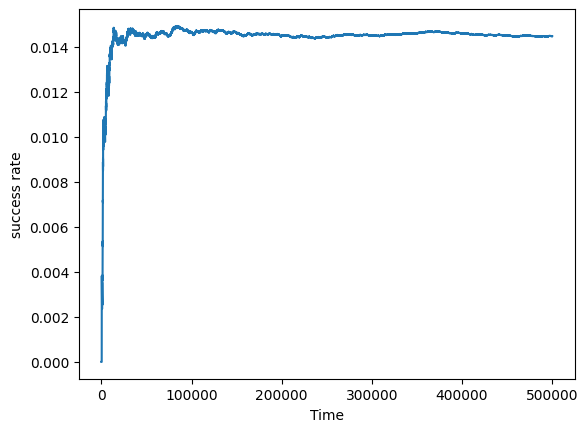

PyObject Text(24.0, 0.5, 'success rate')

In [25]:
plot(success_rate[2:end])
xlabel("Time")
ylabel("success rate")